In [ ]:
import matplotlib.pyplot as plt
import specsuite as ss
import numpy as np

## __What is KOSMOS?__
Attached to the 3.5-meter telescope at Apache Point Observatory is the Kitt Peak Ohio State Multi-Object Spectrograph (KOSMOS). This is a long-slit multi-object spectograph capable of observing from blue-visible into near-infrared wavelengths of light with a resolving power of approximately 2600. Since this is a ground-based telescope, it is subject to the time-dependent contamination of Earth's atmosphere.

In the following reduction, we process five exposures of TOI-3884 using KOSMOS' red grism (~5600-9400 Anstroms). We will not perform a wavelength calibration (since this relies on interactive code), and we will not perform a flux calibration (in an attempt to keep as little data as possible on the GitHub repository).

## __Reduction__
### _Loading Data_
Data taken from KOSMOS is relatively simple to process. It has a single gain value shared across all pixels (stored in metadata as "GAIN") and does not split up its two chips into separate portions of the FITS file. This means we can use the same function calls showed in the preceeding documentation!

In [2]:
CAL_PATH = "../data/KOSMOS/calibrations"
DATA_PATH = "../data/KOSMOS/target"
DATA_REGION = (175, 300)

# Loads standard calibration images
bias = ss.average_matching_files(
    path = CAL_PATH,
    tag = "bias",
    instrument = "KOSMOS",
    crop_bds = DATA_REGION,
)
raw_flat = ss.average_matching_files(
    path = CAL_PATH,
    tag = "flat", 
    instrument="KOSMOS",
    crop_bds = DATA_REGION,
)
raw_arc = ss.average_matching_files(
    path = CAL_PATH,
    tag = "neon",
    instrument = "KOSMOS",
    crop_bds = DATA_REGION,
)

# Loads target object exposures
raw_science = ss.collect_images_array(
    path = DATA_PATH,
    tag = "toi3884",
    instrument = "KOSMOS",
    crop_bds = DATA_REGION,
)

Before we proceed with our reduction, it's worth pointing out two specific features...

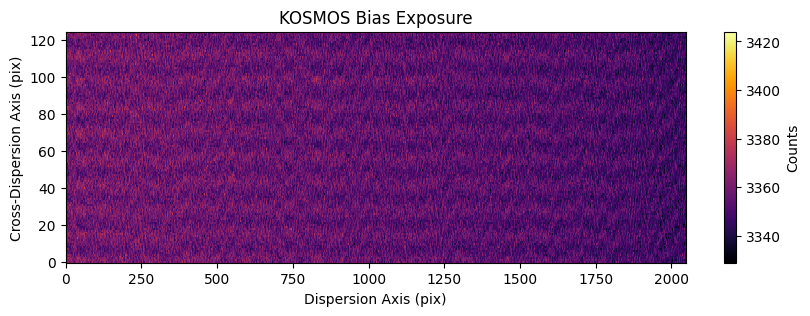

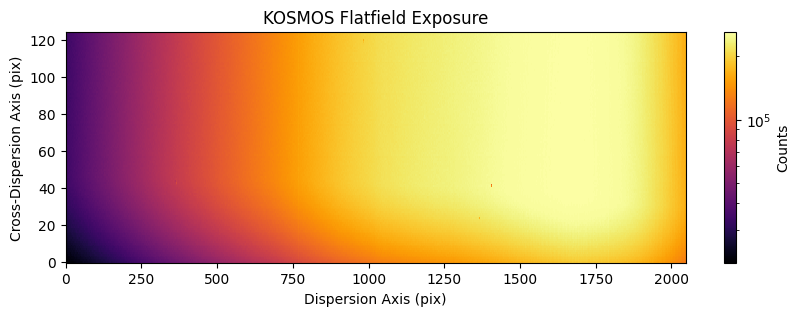

In [3]:
ss.plot_image(
    bias,
    title = "KOSMOS Bias Exposure",
)

ss.plot_image(
    raw_flat,
    norm = 'log',
    title = "KOSMOS Flatfield Exposure",
)

Firstly, the bias exposure has a clear geometric pattern shown up across the detector. The APO technical documentation describes this as "herringbone noise" and is completely normal for the instrument, but should be mitigated as much as possible by averaging exposures where appropriate. Secondly, the flatfield (although hard to see) is saturated toward the right end of the detector. We mistakenly forgot to use a neutral density filter (ND5) to reduce the intensity of the internal quart lamp. Due to this inaccuracy, we will not perform a flatfield calibration in this example.

Since we are dropping the flatfield exposure, we only need to subtract of the bias for our arclamp / science exposures...

In [4]:
arc = raw_arc - bias
science = raw_science - bias

<div class="admonition note">
    <p class="admonition-title">Note</p>
    <p>
        For many telescopes, you may also take a series of "dark" exposures to see how much light your instrument gives off when not illuminated. While this is typically good practice, dark current contamination is too low to significantly impact our reduction. APO's technical documentation estimates that dark current only contributes ~1 DN / minute.
    </p>
</div>

### _Background Extraction_
Next, we will develop a "warp model" that describes how light is curved onto our detector. To do this, you will need an arclamp exposure and a list of pixel locations where you have identified strong line emissions. You can retrieve these line positions using...

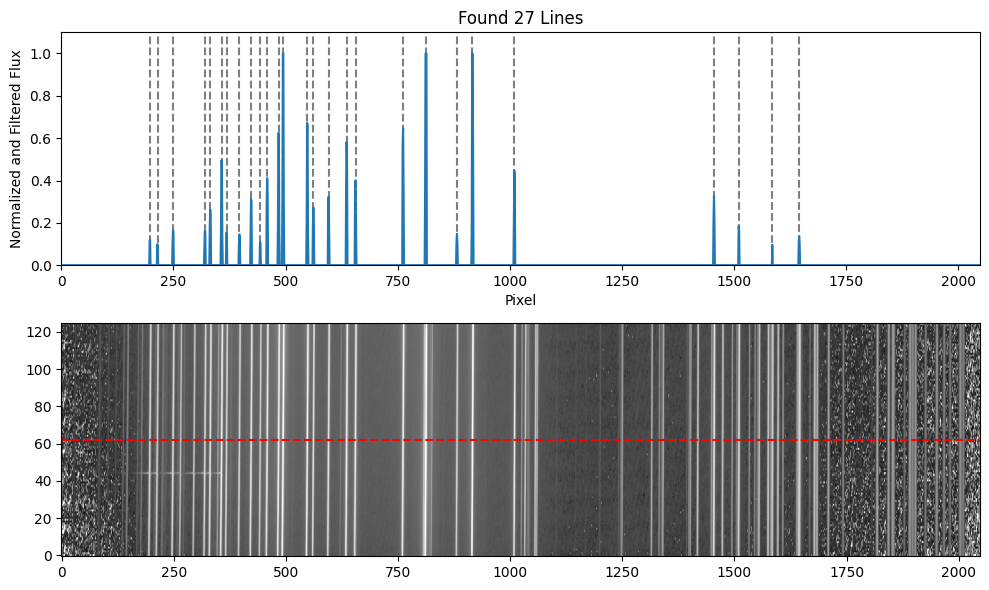

In [5]:
line_locations, rel_intensities = ss.find_cal_lines(
    image = arc,
    std_variation = 250,
    debug = True,
)

In the above plot, you should hopefully see a significant number of well-separated lines. If your threshold (set by ```std_variations```) is set too low, then you risk accidentally lumping together many nearby features into one effective location. Once you satisfied with the above line positions, we feed them (along with our arclamp exposure) into...

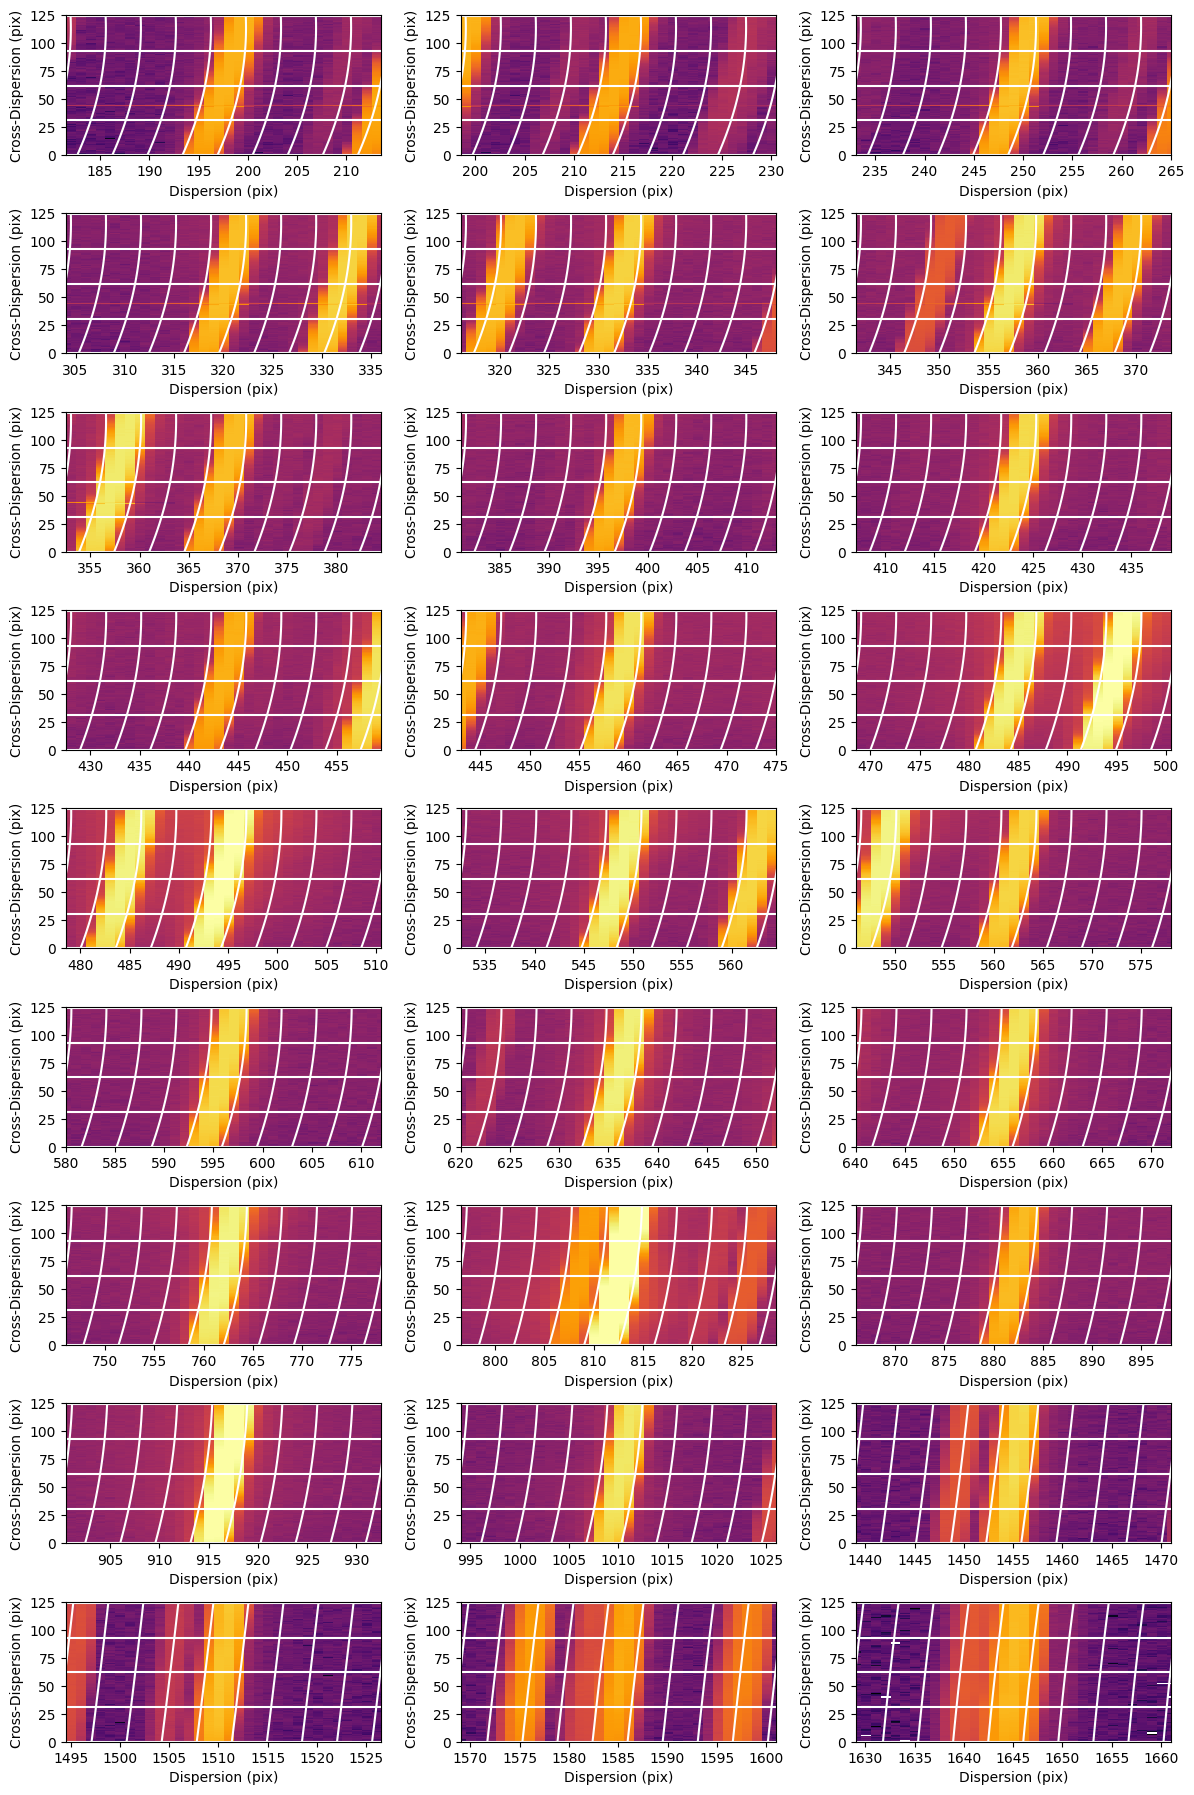

In [6]:
warp_model = ss.generate_warp_model(
    image = arc,
    guess = line_locations,
    debug = True,
)

In this plot, we are checking to make sure that the white grid does a *decent* job of following the shape of lines in that region. We can see how lines in the upper subplots are much more curved than lines in the lower subplots. Since the white grid seems to be accurately tracing out these lines, we can use this "warp model" to extract the background exposures using...

Extracting Background: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


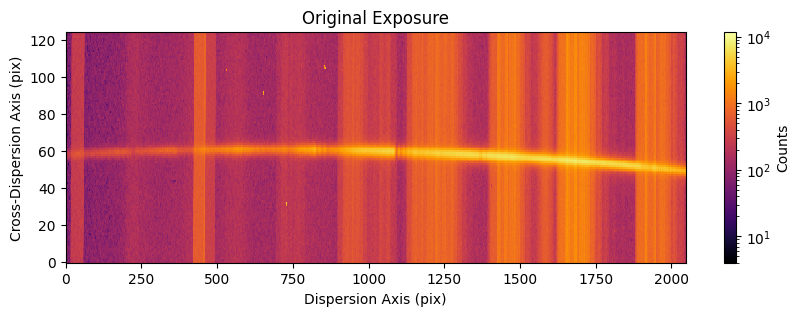

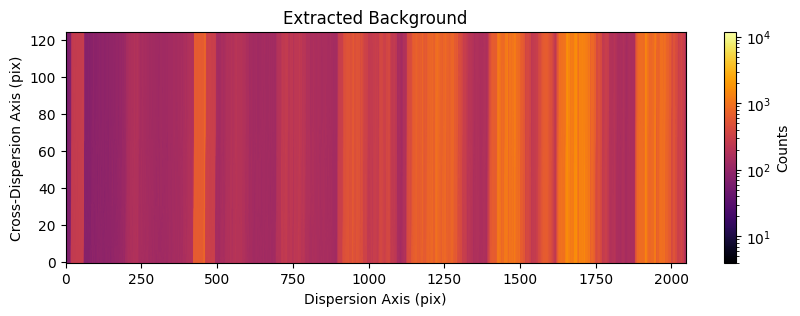

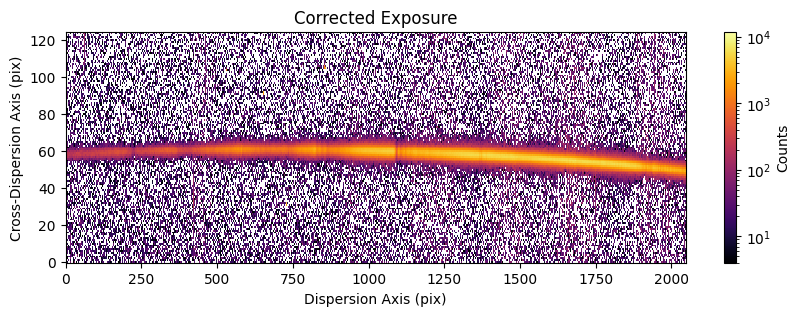

In [ ]:
backgrounds = ss.extract_background(
    images = science,
    warp_model = warp_model,
    mask_region = (40, 80),
    debug = True,
)

If the warp model is accurate and the extraction was a success, the "corrected exposure" should look like our signal trace with surrounding visual static. This random static is an indication that all geometry in our background exposures have been accurately removed!

### _Flux Extraction_
There are currently two method available for extracting flux from your science exposures. These correspond with the standard "boxcar" and "horne (optimal)" extractions used in many other reduction pipelines. Since the boxcar extraction is less likely to hit a snag and fail, let's start there...

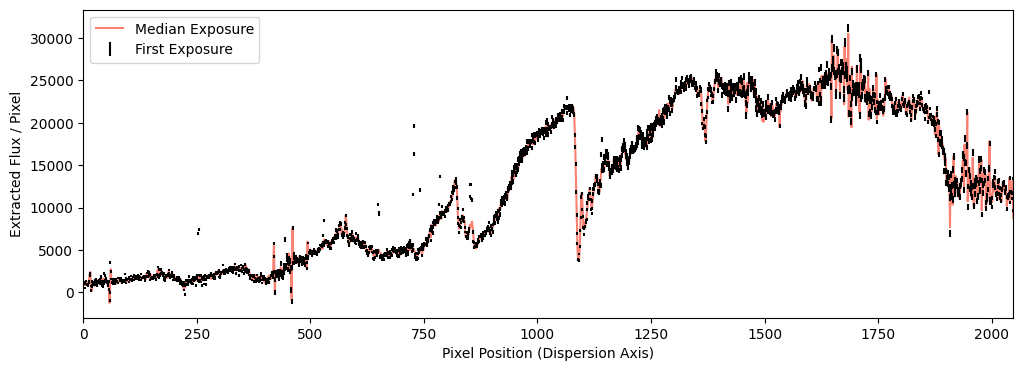

In [8]:
boxcar_flux, boxcar_error = ss.boxcar_extraction(
    images = science - backgrounds,
    backgrounds = backgrounds,
    RN = 6.0,
    debug = True,
)

Note how the extracted SED is pretty noisy! We can also see a fair number of points that lie far above the median SED (caused by cosmic rays). Both of these are somewhat mitigated by using a profile-weighted extraction...

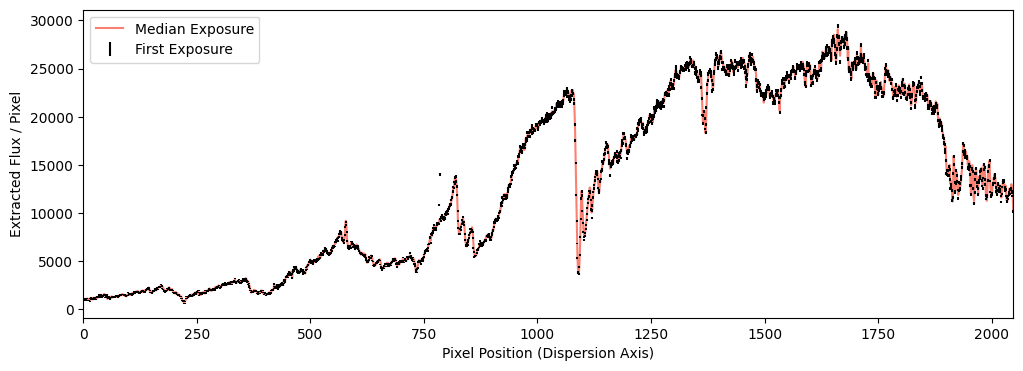

In [9]:
horne_flux, horne_error = ss.horne_extraction(
    images = science - backgrounds,
    backgrounds = backgrounds,
    RN = 6.0,
    debug = True,
)

This looks a lot cleaner! However, one major drawback is that it runs much slower that the boxcar extraction. In general, the boxcar extraction is useful for getting a quick look at your data, and the profile-weighted extraction is best for high-quality reductions. One easy way to compare the quality of both reduction methods is to look that the SNR of the extracted spectra...

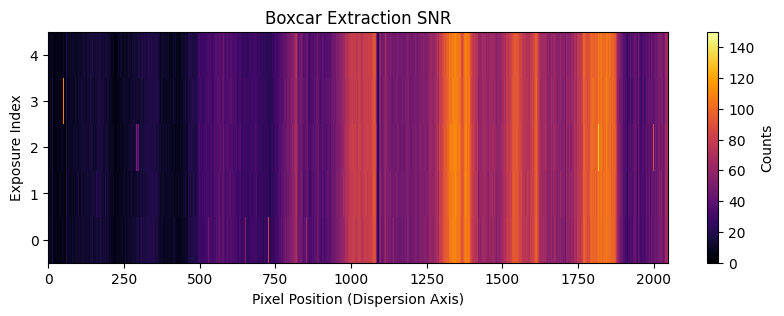

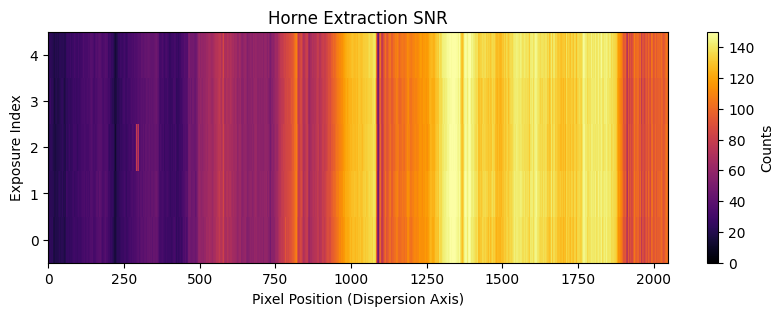

In [10]:
# Plots Boxcar Extraction
ss.plot_image(
    boxcar_flux/boxcar_error,
    title = "Boxcar Extraction SNR",
    xlabel = "Pixel Position (Dispersion Axis)",
    ylabel = "Exposure Index",
    vmin = 0,
    vmax = 150,
)

# Plots Horne Extraction
ss.plot_image(
    horne_flux/horne_error,
    title = "Horne Extraction SNR",
    xlabel="Pixel Position (Dispersion Axis)",
    ylabel="Exposure Index",
    vmin = 0,
    vmax = 150,
)

Note how the boxcar extraction produces a much lower SNR than the Horne extraction (particularly at faint wavelengths)!

## __What Comes Next?__

Once you have an extracted SED, your next steps will depend greatly on the purpose of your observation. If you care about the flux-calibrated SED of your target, then you will need to use some of the functions outlined in ```Additional Tools > Flux Calibration```. If you are only interested in the relative changes in brightness for your target, then you may need to repeat the above reduction for another in-slit comparison star.

Regardless, you will likely need to perform a wavelength calibration to convert pixel position into units of wavelength. Consider using our interactive widget for this!

In [11]:
# Fill with your own data
pixel_list = [...]
wavelength_list = [...]

# Initialize widget
wavecal_widget = ss.WavecalWidget(
    upper_lines = pixel_list,
    lower_lines = wavelength_list,
)

#wavecal_widget.activate_widget()   <--- Uncomment this to use widget

![Initial widget layout](../assets/widget_initial_configuration.png)